In [10]:
%pip install pandas scikit-learn numpy

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DebertaV2Tokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
import sentencepiece


In [17]:
# Load dataset and map labels
df = pd.read_csv("/Users/rafaelzieganpalg/Projects/SRP_Lab/Main_Proj/Dataset/movie_reviews_dataset.csv")
label_map = {"Constructive Criticism": 0, "Hate Speech": 1}
df["label"] = df["label"].map(label_map)

# Split dataset (80% train, 20% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["review"].tolist(), df["label"].tolist(), test_size=0.2, stratify=df["label"], random_state=42
)


In [ ]:
model_name = "microsoft/deberta-v3-base"
tokenizer = DebertaV2Tokenizer.from_pretrained(model_name)

def tokenize_function(texts):
    return tokenizer(texts, truncation=True, padding=True)

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)


ImportError: 
DebertaV2Tokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.


In [10]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        # Create tensor for each encoding field
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = ReviewsDataset(train_encodings, train_labels)
test_dataset = ReviewsDataset(test_encodings, test_labels)


In [13]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Define compute_metrics to calculate accuracy and weighted F1 score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

# TrainingArguments will handle logging (including ETA) and evaluation per epoch.
training_args = TrainingArguments(
    output_dir="./bert_output",
    num_train_epochs=3,                # Adjust number of epochs as needed
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qz/4lvfrztd25sbj6qm6rkb9kk80000gn/T/ipykernel_1394/1809783862.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
# This will print epoch progress, ETA, loss, and computed metrics.
trainer.train()

# Evaluate on the test set
eval_results = trainer.evaluate(test_dataset)
print("Evaluation results:", eval_results)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.000000,0.000029,1.000000,1.000000
2,0.000000,0.000013,1.000000,1.000000
3,0.000000,0.000011,1.000000,1.000000


Evaluation results: {'eval_loss': 2.923758620454464e-05, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_runtime': 2.9132, 'eval_samples_per_second': 274.609, 'eval_steps_per_second': 34.326, 'epoch': 3.0}


Confusion Matrix:
 [[400   0]
 [  0 400]]
Normalized Confusion Matrix:
 [[1. 0.]
 [0. 1.]]


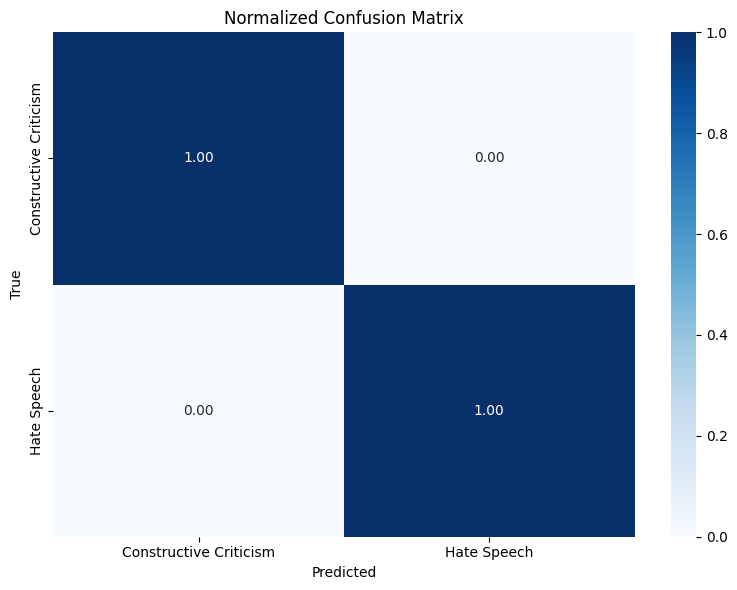

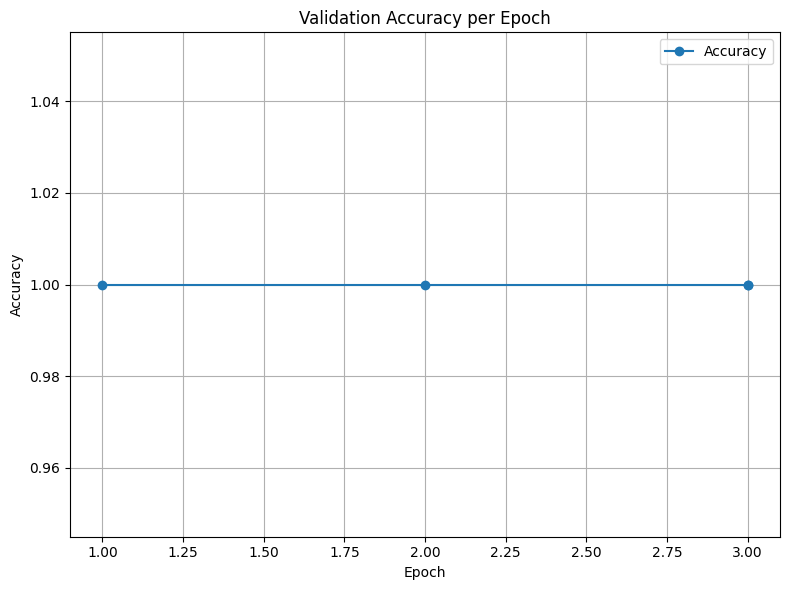

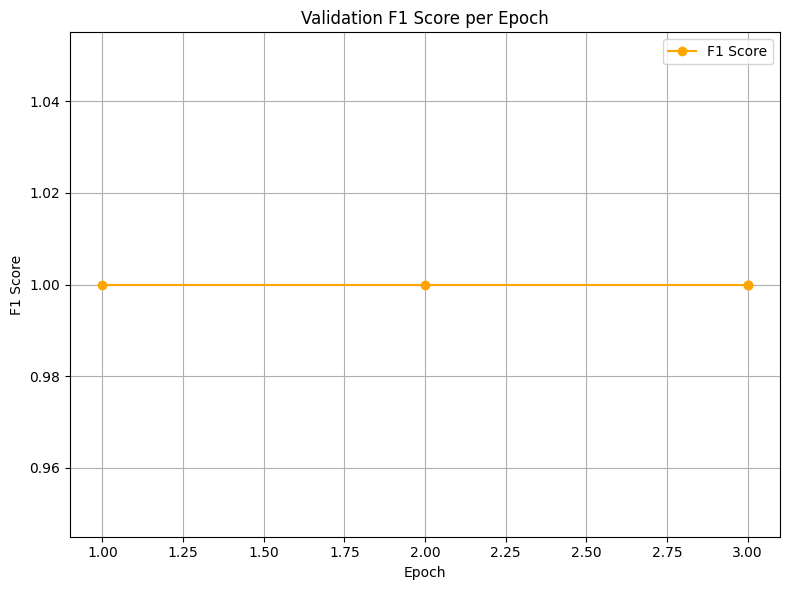

In [15]:
# Obtain predictions on the test set
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=-1)

# Compute confusion matrix and normalize it
cm = confusion_matrix(test_labels, preds)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
print("Confusion Matrix:\n", cm)
print("Normalized Confusion Matrix:\n", cm_normalized)

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Constructive Criticism", "Hate Speech"],
            yticklabels=["Constructive Criticism", "Hate Speech"])
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("normalized_confusion_matrix.png")
plt.show()

# Retrieve logged metrics for plotting accuracy and F1 score over epochs.
logs = trainer.state.log_history
epochs = []
eval_acc = []
eval_f1 = []

# The log_history contains entries logged at evaluation steps.
for log in logs:
    if "epoch" in log and "eval_accuracy" in log and "eval_f1" in log:
        epochs.append(log["epoch"])
        eval_acc.append(log["eval_accuracy"])
        eval_f1.append(log["eval_f1"])

# Plot accuracy chart
if epochs and eval_acc:
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, eval_acc, marker="o", label="Accuracy")
    plt.title("Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("accuracy_chart.png")
    plt.show()

# Plot F1 score chart
if epochs and eval_f1:
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, eval_f1, marker="o", color="orange", label="F1 Score")
    plt.title("Validation F1 Score per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("f1_score_chart.png")
    plt.show()

In [16]:
# ------------------------------
model.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_model")
print("BERT model and tokenizer saved successfully!")

BERT model and tokenizer saved successfully!
